# Dataset Preparation: Downloading Input Files for DTI-CNN Model from Peng et al. (BMC Bioinformatics, 2020)


In [ ]:
import gdown
import os

os.makedirs('data', exist_ok=True)

files = [
    {'name': 'Similarity_Matrix_Proteins.txt', 'url': 'https://drive.google.com/uc?id=1gquLYKwL3zYOAn7sF7chk0TdO8hqcFEo'},
    {'name': 'Similarity_Matrix_Drugs.txt', 'url': 'https://drive.google.com/uc?id=19jxq3-49d10iEfnni9EvESUQrwt9L34I'},
    {'name': 'protein.txt', 'url': 'https://drive.google.com/uc?id=1WDa6RnU0phkCnQfT1NMRjlQcZwRQXWZe'},
    {'name': 'mat_protein_protein.txt', 'url': 'https://drive.google.com/uc?id=1jMueorza0r2e9KBVxdgYpHyzMaHrn2WM'},
    {'name': 'mat_protein_disease.txt', 'url': 'https://drive.google.com/uc?id=1LZplFAT_maRrtzMTmmput2nArRb7EJ-k'},
    {'name': 'mat_drug_se.txt', 'url': 'https://drive.google.com/uc?id=1G5afdkP2xiyizjOVhliFfgg_v0TdJskF'},
    {'name': 'mat_drug_protein.txt', 'url': 'https://drive.google.com/uc?id=1_-O7h8cIJpC0UCAeAIvN6ApN_-aGLBNA'},
    {'name': 'mat_drug_drug.txt', 'url': 'https://drive.google.com/uc?id=1JIVEARFJyOE0k9DXi5hwfSJaChZVzq_t'},
    {'name': 'mat_drug_disease.txt', 'url': 'https://drive.google.com/uc?id=1gC_U-3BuJcR1pV8mqKMz_7y0uRX6wCAG'},
    {'name': 'drug.txt', 'url': 'https://drive.google.com/uc?id=1DEnV7RqGhn3mTk-7fCLUvj-_tkQ_3d8t'},
    {'name': 'mat_drug_protein_remove_homo.txt', 'url': 'https://drive.google.com/uc?id=1i0lYhFSrpUrnNyXoplyBDULcePoVsAK-'},
    {'name': 'se.txt', 'url': 'https://drive.google.com/uc?id=1ExPcXnkypA90HwE5vXJJPzOhLEKAgLeI'},
    {'name': 'disease.txt', 'url': 'https://drive.google.com/uc?id=19v_Zccb4tdXPlondvcIItbEdDXXpdIgd'}
]

for file in files:
    output = f"data/{file['name']}"
    gdown.download(file['url'], output, quiet=False)

print("All files downloaded.")

Downloading...
From: https://drive.google.com/uc?id=1gquLYKwL3zYOAn7sF7chk0TdO8hqcFEo
To: /content/data/Similarity_Matrix_Proteins.txt
100%|██████████| 22.7M/22.7M [00:00<00:00, 85.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=19jxq3-49d10iEfnni9EvESUQrwt9L34I
To: /content/data/Similarity_Matrix_Drugs.txt
100%|██████████| 8.84M/8.84M [00:00<00:00, 42.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WDa6RnU0phkCnQfT1NMRjlQcZwRQXWZe
To: /content/data/protein.txt
100%|██████████| 10.6k/10.6k [00:00<00:00, 29.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jMueorza0r2e9KBVxdgYpHyzMaHrn2WM
To: /content/data/mat_protein_protein.txt
100%|██████████| 4.57M/4.57M [00:00<00:00, 31.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LZplFAT_maRrtzMTmmput2nArRb7EJ-k
To: /content/data/mat_protein_disease.txt
100%|██████████| 16.9M/16.9M [00:00<00:00, 74.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G5afdkP2xiyizjOVhliFfgg_v0TdJskF
To: /conte

All files downloaded.


# Step 1: Extracting Drug and Protein Features Using Jaccard Similarity and Random Walk with Restart (RWR)

In [ ]:
import numpy as np
import os

# ----------- 1. Jaccard Similarity ------------------
def jaccard_similarity(adj_matrix):
    n = adj_matrix.shape[0]
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        Ai = adj_matrix[i]
        for j in range(i, n):
            Aj = adj_matrix[j]
            union = np.logical_or(Ai, Aj).sum()
            if union == 0:
                sim = 0
            else:
                sim = np.logical_and(Ai, Aj).sum() / union
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim
    return sim_matrix

# ----------- 2. RWR ------------------
def normalize_matrix(A):
    row_sums = A.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1e-12
    return A / row_sums

def rwr(A, restart_prob=0.5, max_iter=20, tol=1e-6):
    B = normalize_matrix(A)
    n = B.shape[0]
    diffusion_states = np.zeros((n, n))
    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        s = e.copy()
        for _ in range(max_iter):
            s_new = (1 - restart_prob) * np.dot(s, B) + restart_prob * e
            if np.linalg.norm(s_new - s, 1) < tol:
                break
            s = s_new
        diffusion_states[i] = s
    return diffusion_states

# ----------- 3. Files ------------------
drug_files = {
    "drug_drug": "mat_drug_drug.txt",
    "drug_disease": "mat_drug_disease.txt",
    "drug_se": "mat_drug_se.txt",
    "drug_sim": "Similarity_Matrix_Drugs.txt"  # بدون Jaccard
}

protein_files = {
    "protein_protein": "mat_protein_protein.txt",
    "protein_disease": "mat_protein_disease.txt",
    "protein_sim": "Similarity_Matrix_Proteins.txt"  # بدون Jaccard
}

# ----------- 4. Run Jaccard + RWR ------------------
def process_file(path, use_jaccard=True):
    mat = np.loadtxt(path)
    sim = jaccard_similarity(mat) if use_jaccard else mat
    return rwr(sim)

# ----------- 5. Generating Drug Feature Vectors ------------------
drug_feature_list = []
for name, filename in drug_files.items():
    print(f"Processing {name} ...")
    path = os.path.join("data", filename)
    use_jaccard = not filename.startswith("Similarity")
    diffused = process_file(path, use_jaccard)
    drug_feature_list.append(diffused)

# ----------- 6. Generating Protein Feature Vectors ------------------
protein_feature_list = []
for name, filename in protein_files.items():
    print(f"Processing {name} ...")
    path = os.path.join("data", filename)
    use_jaccard = not filename.startswith("Similarity")
    diffused = process_file(path, use_jaccard)
    protein_feature_list.append(diffused)

# ----------- 7. Merging All Features into Final Matrices ------------------
drug_feature_matrix = np.concatenate(drug_feature_list, axis=1)     # (708, 2832)
protein_feature_matrix = np.concatenate(protein_feature_list, axis=1)  # (1512, 4536)

print("✅ Drug features shape:", drug_feature_matrix.shape)
print("✅ Protein features shape:", protein_feature_matrix.shape)

# ----------- 8. Saving Drug and Protein Feature Matrices ------------------
np.save("drug_features.npy", drug_feature_matrix)
np.save("protein_features.npy", protein_feature_matrix)


Processing drug_drug ...
Processing drug_disease ...
Processing drug_se ...
Processing drug_sim ...
Processing protein_protein ...
Processing protein_disease ...
Processing protein_sim ...
✅ Drug features shape: (708, 2832)
✅ Protein features shape: (1512, 4536)


# Step 2: Dimensionality Reduction Using Denoising Autoencoder (DAE) for Drug and Protein Features

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from sklearn.preprocessing import MinMaxScaler

# ----------- 1. Load features from RWR ----------------
X_drug = np.load("drug_features.npy")       # (708, 2832)
X_protein = np.load("protein_features.npy") # (1512, 4536)

# ----------- 2. Normalize features ----------------
scaler_drug = MinMaxScaler()
X_drug_norm = scaler_drug.fit_transform(X_drug)

scaler_protein = MinMaxScaler()
X_protein_norm = scaler_protein.fit_transform(X_protein)

# ----------- 3. Define Denoising Autoencoder ----------------
def build_dae(input_dim, hidden_dim):
    input_layer = layers.Input(shape=(input_dim,))
    noisy_input = layers.GaussianNoise(0.2)(input_layer)
    encoded = layers.Dense(hidden_dim, activation='softplus')(noisy_input)
    decoded = layers.Dense(input_dim, activation='linear')(encoded)
    dae = models.Model(inputs=input_layer, outputs=decoded)
    encoder = models.Model(inputs=input_layer, outputs=encoded)
    dae.compile(optimizer=optimizers.RMSprop(), loss=losses.MeanSquaredError())
    return dae, encoder

# ----------- 4. Train DAE for drugs ----------------
dae_drug, encoder_drug = build_dae(X_drug.shape[1], 100)
dae_drug.fit(X_drug_norm, X_drug_norm,
             epochs=30,
             batch_size=16,
             shuffle=True,
             validation_split=0.1,
             verbose=1)

X_drug_encoded = encoder_drug.predict(X_drug_norm)
print("✅ Encoded Drug Features Shape:", X_drug_encoded.shape)

# ----------- 5. Train DAE for proteins ----------------
dae_protein, encoder_protein = build_dae(X_protein.shape[1], 400)
dae_protein.fit(X_protein_norm, X_protein_norm,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_split=0.1,
                verbose=1)

X_protein_encoded = encoder_protein.predict(X_protein_norm)
print("✅ Encoded Protein Features Shape:", X_protein_encoded.shape)

# ----------- 6. Save encoded outputs ----------------
np.save("X_drug_encoded.npy", X_drug_encoded)         # (708, 100)
np.save("X_protein_encoded.npy", X_protein_encoded)   # (1512, 400)


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0141 - val_loss: 0.0015
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_l

# Step 3: Drug-Target Interaction Prediction Using CNN with 10-Fold Cross-Validation and Performance Evaluation (AUROC, AUPR)


🔁 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
AUROC: 0.8939 | AUPR: 0.8944

🔁 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
AUROC: 0.8876 | AUPR: 0.9046

🔁 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
AUROC: 0.8920 | AUPR: 0.8789

🔁 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
AUROC: 0.8775 | AUPR: 0.8689

🔁 Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
AUROC: 0.8901 | AUPR: 0.8669

🔁 Fold 6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
AUROC: 0.8912 | AUPR: 0.8776

🔁 Fold 7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
AUROC: 0.8966 | AUPR: 0.9196

🔁 Fold 8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
AUROC: 0.8697 | AUPR: 0.8606

🔁 Fold 9


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
AUROC: 0.8596 | AUPR: 0.8755

🔁 Fold 10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
AUROC: 0.8510 | AUPR: 0.8835

✅ Final Average AUROC: 0.8809220572304705
✅ Final Average AUPR: 0.8830425445763821
📊 Mean AUROC (curve): 0.8807684628192006
📊 Mean AUPR (curve): 0.8876682522383024


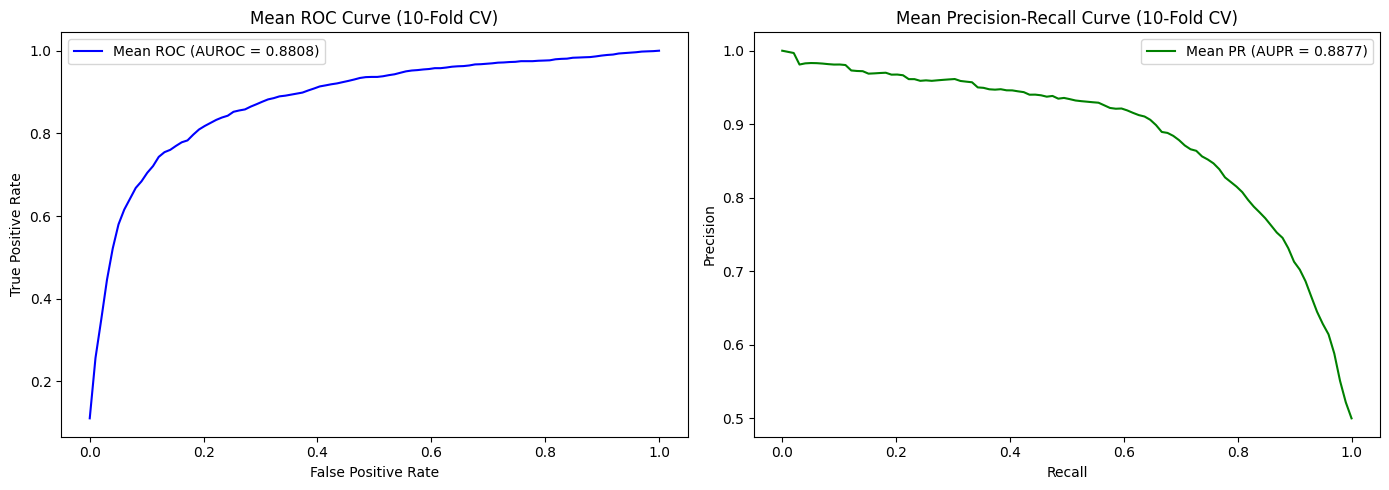

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, auc
)

# --------------------- 1. Load reduced features and interaction matrix ---------------------
X_drug = np.load("X_drug_encoded.npy")       # (708, 100)
X_protein = np.load("X_protein_encoded.npy") # (1512, 400)
mat_dp = np.loadtxt("data/mat_drug_protein.txt")  # (708, 1512)

# --------------------- 2. Check shape consistency ---------------------
assert X_drug.shape[0] == mat_dp.shape[0], "Drug count mismatch!"
assert X_protein.shape[0] == mat_dp.shape[1], "Protein count mismatch!"

# --------------------- 3. Build drug-target interaction dataset ---------------------
def build_dataset(X_drug, X_protein, mat_dp, negative_ratio=1.0):
    pos_pairs = np.argwhere(mat_dp == 1)
    num_pos = pos_pairs.shape[0]

    num_neg = int(num_pos * negative_ratio)
    neg_candidates = np.argwhere(mat_dp == 0)
    np.random.shuffle(neg_candidates)
    neg_pairs = neg_candidates[:num_neg]

    all_pairs = np.concatenate([pos_pairs, neg_pairs])
    labels = np.concatenate([np.ones(len(pos_pairs)), np.zeros(len(neg_pairs))])

    idx = np.arange(len(labels))
    np.random.shuffle(idx)

    all_pairs = all_pairs[idx]
    labels = labels[idx]

    X = np.array([
        np.concatenate([X_drug[i], X_protein[j]]) for i, j in all_pairs
    ])

    return X, labels

# --------------------- 4. Define CNN model ---------------------
def build_cnn(input_dim=500):
    model = models.Sequential([
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        layers.Conv1D(filters=16, kernel_size=4, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2),
        layers.Flatten(),
        layers.Dense(180, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name="auroc"),
                           tf.keras.metrics.AUC(curve='PR', name="aupr")])
    return model

# --------------------- 5. Cross-validation (with mean ROC/PR curve calculation) ---------------------
X, y = build_dataset(X_drug, X_protein, mat_dp, negative_ratio=1.0)
kf = KFold(n_splits=10)

auroc_scores = []
aupr_scores = []

# Save all folds' ROC/PR curves
tpr_list = []
fpr_list = []
prec_list = []
rec_list = []

mean_fpr = np.linspace(0, 1, 100)
mean_rec = np.linspace(0, 1, 100)

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold + 1}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = build_cnn(input_dim=X.shape[1])
    model.fit(X_train, y_train, epochs=35, batch_size=64, verbose=0)

    y_pred = model.predict(X_test).flatten()

    auroc = roc_auc_score(y_test, y_pred)
    aupr = average_precision_score(y_test, y_pred)

    print(f"AUROC: {auroc:.4f} | AUPR: {aupr:.4f}")
    auroc_scores.append(auroc)
    aupr_scores.append(aupr)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    prec, rec, _ = precision_recall_curve(y_test, y_pred)

    # Interpolate to common x-axis for averaging
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    rec_interp = np.interp(mean_rec, rec[::-1], prec[::-1])  # Flip for monotonicity

    tpr_list.append(tpr_interp)
    rec_list.append(rec_interp)

# Compute mean curves
mean_tpr = np.mean(tpr_list, axis=0)
mean_prec = np.mean(rec_list, axis=0)

# Compute AUCs of the mean curves
mean_auroc = auc(mean_fpr, mean_tpr)
mean_aupr = auc(mean_rec, mean_prec)

print("\n✅ Final Average AUROC:", np.mean(auroc_scores))
print("✅ Final Average AUPR:", np.mean(aupr_scores))
print("📊 Mean AUROC (curve):", mean_auroc)
print("📊 Mean AUPR (curve):", mean_aupr)

# --------------------- 6. Plot Mean ROC and PR Curves ---------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Mean ROC Curve
plt.subplot(1, 2, 1)
plt.plot(mean_fpr, mean_tpr, color='blue', label=f"Mean ROC (AUROC = {mean_auroc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curve (10-Fold CV)")
plt.legend()

# Mean PR Curve
plt.subplot(1, 2, 2)
plt.plot(mean_rec, mean_prec, color='green', label=f"Mean PR (AUPR = {mean_aupr:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Mean Precision-Recall Curve (10-Fold CV)")
plt.legend()

plt.tight_layout()
plt.show()

# Case Study: Train CNN on Excluded Set and Evaluate Predictive Power for Quetiapine, Olanzapine, and Meprobamate

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_auc_score, average_precision_score

# ------------------- 1. Load data -------------------
X_drug = np.load("X_drug_encoded.npy")
X_protein = np.load("X_protein_encoded.npy")
mat_dp = np.loadtxt("data/mat_drug_protein.txt")

# Map drug IDs to indices
with open("data/drug.txt") as f:
    drug_ids = [line.strip() for line in f]

# Define drugs for case study
case_study_drugs = {
    "DB01224": "Quetiapine",
    "DB00334": "Olanzapine",
    "DB00371": "Meprobamate"
}

target_indices = {id_: drug_ids.index(id_) for id_ in case_study_drugs}

# ------------------- 2. Remove case drugs from training -------------------
all_positive = np.argwhere(mat_dp == 1)
excluded_drugs = list(target_indices.values())
mask = ~np.isin(all_positive[:, 0], excluded_drugs)
train_positive = all_positive[mask]

# Build negative samples
all_negative = np.argwhere(mat_dp == 0)
np.random.shuffle(all_negative)
train_negative = all_negative[:len(train_positive)]

# Create training data
train_pairs = np.concatenate([train_positive, train_negative])
train_labels = np.concatenate([np.ones(len(train_positive)), np.zeros(len(train_negative))])

X_train = np.array([
    np.concatenate([X_drug[i], X_protein[j]]) for i, j in train_pairs
])
y_train = train_labels

# ------------------- 3. Define and train CNN model -------------------
def build_cnn(input_dim=500):
    model = tf.keras.Sequential([
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        layers.Conv1D(filters=16, kernel_size=4, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2),
        layers.Flatten(),
        layers.Dense(180, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

model = build_cnn(input_dim=X_train.shape[1])
model.fit(X_train, y_train, epochs=35, batch_size=64, verbose=1)

# ------------------- 4. Evaluate case drugs -------------------
for drug_id, drug_name in case_study_drugs.items():
    d_idx = drug_ids.index(drug_id)
    true_targets = np.where(mat_dp[d_idx] == 1)[0]

    test_X = np.array([
        np.concatenate([X_drug[d_idx], X_protein[j]]) for j in range(X_protein.shape[0])
    ])
    y_pred = model.predict(test_X).flatten()

    true_scores = y_pred[true_targets]
    threshold = np.percentile(y_pred, 80)
    num_detected = np.sum(true_scores >= threshold)
    total_true = len(true_targets)

    print(f"\n📌 Case Study: {drug_name} ({drug_id})")
    print(f"Known interactions: {total_true}")
    print(f"Predicted above 80th percentile threshold: {num_detected}")
    print(f"Detection Rate: {num_detected / total_true:.2%}")


Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.6702
Epoch 2/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5037
Epoch 3/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4206
Epoch 4/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3601
Epoch 5/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3100
Epoch 6/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2773
Epoch 7/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2318
Epoch 8/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2050
Epoch 9/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1831
Epoch 10/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1466
Epoch 11/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1407
Epoch 12/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1074
Epoch 13/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0981
Epoch 14/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0887
Epoch 15/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0781
Epoch 16/35
59/59 ━━━━━━━━━━━

# Comparative Evaluation of DTI-CNN, SVD-CNN, and DTI-SVM with ROC and PR Curves

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


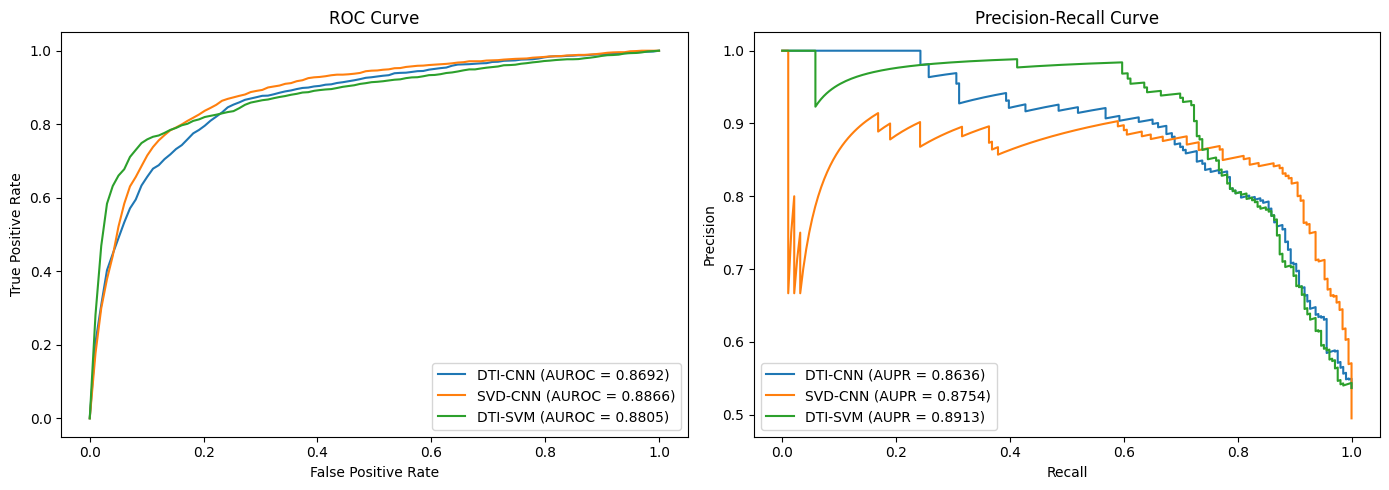

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# ----------------- Load -----------------
X_drug_dae = np.load("X_drug_encoded.npy")       # (708, 100)
X_protein_dae = np.load("X_protein_encoded.npy") # (1512, 400)
mat_dp = np.loadtxt("data/mat_drug_protein.txt")

X_drug_raw = np.load("drug_features.npy")        # (708, 2832)
X_protein_raw = np.load("protein_features.npy")  # (1512, 4536)

# ----------------- Dataset builder -----------------
def build_dataset(X_drug, X_protein, mat_dp, negative_ratio=1.0):
    pos_pairs = np.argwhere(mat_dp == 1)
    num_pos = pos_pairs.shape[0]
    num_neg = int(num_pos * negative_ratio)

    neg_candidates = np.argwhere(mat_dp == 0)
    np.random.shuffle(neg_candidates)
    neg_pairs = neg_candidates[:num_neg]

    all_pairs = np.concatenate([pos_pairs, neg_pairs])
    labels = np.concatenate([np.ones(len(pos_pairs)), np.zeros(len(neg_pairs))])

    idx = np.arange(len(labels))
    np.random.shuffle(idx)

    all_pairs = all_pairs[idx]
    labels = labels[idx]

    X = np.array([
        np.concatenate([X_drug[i], X_protein[j]]) for i, j in all_pairs
    ])
    return X, labels

# ----------------- CNN Model -----------------
def build_cnn(input_dim=500):
    model = tf.keras.Sequential([
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        layers.Conv1D(filters=16, kernel_size=4, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2, strides=2),
        layers.Flatten(),
        layers.Dense(180, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

# ----------------- Evaluation wrapper -----------------
def evaluate_model(X, y, model_builder, use_svm=False):
    kf = KFold(n_splits=10)
    mean_fpr = np.linspace(0, 1, 100)
    tprs, precisions, recalls = [], [], []
    auroc_list, aupr_list = [], []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if use_svm:
            model = model_builder()
            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            model = model_builder(X.shape[1])
            model.fit(X_train, y_train, epochs=35, batch_size=64, verbose=0)
            y_score = model.predict(X_test).flatten()

        # Metrics
        auroc = roc_auc_score(y_test, y_score)
        aupr = average_precision_score(y_test, y_score)
        auroc_list.append(auroc)
        aupr_list.append(aupr)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        prec, rec, _ = precision_recall_curve(y_test, y_score)

        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        precisions.append(prec)
        recalls.append(rec)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    return {
        "auroc": np.mean(auroc_list),
        "aupr": np.mean(aupr_list),
        "fpr": mean_fpr,
        "tpr": mean_tpr,
        "precision": precisions[-1],
        "recall": recalls[-1]
    }

# ----------------- 1. DTI-CNN -----------------
X_dti_cnn, y = build_dataset(X_drug_dae, X_protein_dae, mat_dp)
result_cnn = evaluate_model(X_dti_cnn, y, build_cnn)

# ----------------- 2. SVD-CNN -----------------
def apply_svd_and_build_dataset(drug_raw, prot_raw, mat_dp, dim_drug=100, dim_prot=400):
    """Apply Truncated SVD to drug and protein feature matrices and return dataset."""
    svd_drug = TruncatedSVD(n_components=dim_drug, random_state=42).fit_transform(drug_raw)
    svd_prot = TruncatedSVD(n_components=dim_prot, random_state=42).fit_transform(prot_raw)
    X_combined, y_labels = build_dataset(svd_drug, svd_prot, mat_dp)
    return X_combined, y_labels

X_svd_cnn, y_svd = apply_svd_and_build_dataset(X_drug_raw, X_protein_raw, mat_dp)
result_svd = evaluate_model(X_svd_cnn, y_svd, build_cnn)

# ----------------- 3. DTI-SVM -----------------
def build_svm(): return SVC(kernel='rbf', probability=True)
result_svm = evaluate_model(X_dti_cnn, y, build_svm, use_svm=True)

# ----------------- Plotting -----------------
plt.figure(figsize=(14, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(result_cnn["fpr"], result_cnn["tpr"], label=f"DTI-CNN (AUROC = {result_cnn['auroc']:.4f})")
plt.plot(result_svd["fpr"], result_svd["tpr"], label=f"SVD-CNN (AUROC = {result_svd['auroc']:.4f})")
plt.plot(result_svm["fpr"], result_svm["tpr"], label=f"DTI-SVM (AUROC = {result_svm['auroc']:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR
plt.subplot(1, 2, 2)
plt.plot(result_cnn["recall"], result_cnn["precision"], label=f"DTI-CNN (AUPR = {result_cnn['aupr']:.4f})")
plt.plot(result_svd["recall"], result_svd["precision"], label=f"SVD-CNN (AUPR = {result_svd['aupr']:.4f})")
plt.plot(result_svm["recall"], result_svm["precision"], label=f"DTI-SVM (AUPR = {result_svm['aupr']:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


# Ablation Study — Evaluating the Contribution of Each Network Type to DTI-CNN Performance


In [ ]:
import numpy as np
import os
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler

# ---------- Ablation configuration ----------
all_networks = {
    "drug-drug": "mat_drug_drug.txt",
    "drug-disease": "mat_drug_disease.txt",
    "drug side-effect": "mat_drug_se.txt",
    "drug similarities": "Similarity_Matrix_Drugs.txt",
    "protein-protein": "mat_protein_protein.txt",
    "protein-disease": "mat_protein_disease.txt",
    "protein similarities": "Similarity_Matrix_Proteins.txt"
}

# ---------- Jaccard Similarity ----------
def jaccard_similarity(adj_matrix):
    n = adj_matrix.shape[0]
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        Ai = adj_matrix[i]
        for j in range(i, n):
            Aj = adj_matrix[j]
            union = np.logical_or(Ai, Aj).sum()
            inter = np.logical_and(Ai, Aj).sum()
            sim = inter / union if union != 0 else 0
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim
    return sim_matrix

# ---------- RWR ----------
def normalize_matrix(A):
    row_sums = A.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1e-12
    return A / row_sums

def rwr(A, restart_prob=0.5, max_iter=20):
    B = normalize_matrix(A)
    n = B.shape[0]
    diffusion_states = np.zeros((n, n))
    for i in range(n):
        e = np.zeros(n)
        e[i] = 1
        s = e.copy()
        for _ in range(max_iter):
            s_new = (1 - restart_prob) * np.dot(s, B) + restart_prob * e
            if np.linalg.norm(s_new - s, 1) < 1e-6:
                break
            s = s_new
        diffusion_states[i] = s
    return diffusion_states

# ---------- Build Features ----------
def build_features(exclude_network):
    drug_features = []
    protein_features = []
    for name, filename in all_networks.items():
        if name == exclude_network:
            continue
        mat = np.loadtxt(f"data/{filename}")
        is_similarity = filename.startswith("Similarity")
        sim = mat if is_similarity else jaccard_similarity(mat)
        diffused = rwr(sim)
        if name.startswith("drug"):
            drug_features.append(diffused)
        else:
            protein_features.append(diffused)
    X_drug = np.concatenate(drug_features, axis=1)
    X_protein = np.concatenate(protein_features, axis=1)
    return X_drug, X_protein

# ---------- DAE ----------
def run_dae(X, hidden_dim, batch_size):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    inp = layers.Input(shape=(X.shape[1],))
    x = layers.GaussianNoise(0.2)(inp)
    encoded = layers.Dense(hidden_dim, activation='softplus')(x)
    decoded = layers.Dense(X.shape[1], activation='linear')(encoded)
    dae = models.Model(inp, decoded)
    encoder = models.Model(inp, encoded)
    dae.compile(optimizer='rmsprop', loss='mse')
    dae.fit(X_scaled, X_scaled, epochs=30, batch_size=batch_size, verbose=0)
    return encoder.predict(X_scaled)

# ---------- CNN ----------
def build_cnn(input_dim):
    model = tf.keras.Sequential([
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        layers.Conv1D(16, 4, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

# ---------- Dataset ----------
def build_dataset(X_drug, X_protein, mat_dp, neg_ratio=1.0):
    pos = np.argwhere(mat_dp == 1)
    num_pos = len(pos)
    neg = np.argwhere(mat_dp == 0)
    np.random.shuffle(neg)
    neg = neg[:int(num_pos * neg_ratio)]
    all_pairs = np.concatenate([pos, neg])
    labels = np.concatenate([np.ones(len(pos)), np.zeros(len(neg))])
    idx = np.random.permutation(len(labels))
    pairs = all_pairs[idx]
    labels = labels[idx]
    X = np.array([np.concatenate([X_drug[i], X_protein[j]]) for i, j in pairs])
    return X, labels

# ---------- Main loop ----------
mat_dp = np.loadtxt("data/mat_drug_protein.txt")
results = []

for network in all_networks.keys():
    print(f"\n🔎 Testing without: {network}")
    X_drug, X_protein = build_features(exclude_network=network)
    X_drug = run_dae(X_drug, hidden_dim=100, batch_size=16)
    X_protein = run_dae(X_protein, hidden_dim=400, batch_size=32)
    X, y = build_dataset(X_drug, X_protein, mat_dp)

    kf = KFold(n_splits=10)
    aurocs, auprs = [], []

    for train_idx, test_idx in kf.split(X):
        model = build_cnn(X.shape[1])
        model.fit(X[train_idx], y[train_idx], epochs=35, batch_size=64, verbose=0)
        y_pred = model.predict(X[test_idx]).flatten()
        aurocs.append(roc_auc_score(y[test_idx], y_pred))
        auprs.append(average_precision_score(y[test_idx], y_pred))

    mean_auroc = np.mean(aurocs)
    mean_aupr = np.mean(auprs)
    results.append((network, mean_auroc, mean_aupr))
    print(f"✅ AUROC: {mean_auroc:.4f} | AUPR: {mean_aupr:.4f}")

# ---------- Final Table ----------
print("\n📊 Final Table - Ablation Study (like Table 3)")
print(f"{'Networks':35s} {'AUROC':>10} {'AUPR':>10}")
for net, auc, apr in results:
    print(f"{'Without ' + net:35s} {auc:10.4f} {apr:10.4f}")



🔎 Testing without: drug-drug
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
✅ AUROC: 0.8783 | AUPR: 0.8727

🔎 Testing without: drug-disease
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
✅ AUROC: 0.8850 | AUPR: 0.8822

🔎 Testing without: drug side-effect
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
✅ AUROC: 0.8745 | AUPR: 0.8738

🔎 Testing without: drug similarities
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
✅ AUROC: 0.8690 | AUPR: 0.8601

🔎 Testing without: protein-protein
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
✅ AUROC: 0.8692 | AUPR: 0.8589

🔎 Testing without: protein-disease
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
✅ AUROC: 0.8755 | AUPR: 0.8719

🔎 Testing without: protein similarities
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
✅ AUROC: 0.8735 | AUPR: 0.8656

📊 Final Table - Ablation Study (like Table 3)
Networks                                 AUROC       AUPR
Without drug-drug                       0.8783     0.8727
Without drug-disease                    0.8850     0.8822
Without drug side-effect                0.8745     0.8738
Without drug similarities               0.8690     0.8601
Without protein-protein                 0.8692     0.8589
Without protein-disease                 0.8755     0.8719
Without protein similarities            0.8735     0.8656
